In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_tensor_type('torch.DoubleTensor')
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.utils import spectral_norm
import numpy as np
import utils
import mlmodel
import matplotlib.pyplot as plt
import collections.abc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
if sys.platform == 'win32':
    NUM_WORKERS = 0 # Windows does not support multiprocessing
else:
    NUM_WORKERS = 2
print('running on ' + sys.platform + ', setting ' + str(NUM_WORKERS) + ' workers')

running on darwin, setting 2 workers


## Load the Dataset

In [4]:
dim_a = 3
features = ['v', 'q', 'pwm']
label = 'fa'

# Training data collected from the neural-fly drone
dataset = 'neural-fly' 
dataset_folder = 'data/training'
hover_pwm_ratio = 1.

# # Training data collected from an intel aero drone
# dataset = 'neural-fly-transfer'
# dataset_folder = 'data/training-transfer'
# hover_pwm = 910 # mean hover pwm for neural-fly drone
# intel_hover_pwm = 1675 # mean hover pwm for intel-aero drone
# hover_pwm_ratio = hover_pwm / intel_hover_pwm # scaling ratio from system id

modelname = f"{dataset}_dim-a-{dim_a}_{'-'.join(features)}" # 'intel-aero_fa-num-Tsp_v-q-pwm'

In [5]:
RawData = utils.load_data(dataset_folder)
Data = utils.format_data(RawData, features=features, output=label)

testdata_folder = 'data/experiment'
TestRawData = utils.load_data(testdata_folder, expnames='(baseline_)([0-9]*|no)wind')
TestData = utils.format_data(RawData, features=features, output=label, hover_pwm_ratio=hover_pwm_ratio) # wind condition label, C, will not make sense for this data - that's okay since C is only used in the training process

In [6]:
options = {}
options['dim_x'] = Data[0].X.shape[1]
options['dim_y'] = Data[0].Y.shape[1]
options['num_c'] = len(Data)
print('dims of (x, y) are', (options['dim_x'], options['dim_y']))
print('there are ' + str(options['num_c']) + ' different conditions')

dims of (x, y) are (11, 3)
there are 6 different conditions


In [7]:
options['features'] = features
options['dim_a'] = dim_a
options['loss_type'] = 'crossentropy-loss'

options['shuffle'] = True # True: shuffle trajectories to data points
options['K_shot'] = 32 # number of K-shot for least square on a
options['phi_shot'] = 256 # batch size for training phi

options['alpha'] = 0.01 # adversarial regularization loss
options['learning_rate'] = 5e-4
options['frequency_h'] = 2 # how many times phi is updated between h updates, on average
options['SN'] = 2. # maximum single layer spectral norm of phi
options['gamma'] = 10. # max 2-norm of a
options['num_epochs'] = 1000

## Process Tasks Data

In [8]:
train_tasks = {}
for i, data in enumerate(Data):
  if data.condition not in train_tasks.keys():
    train_tasks[data.condition] = []
  train_tasks[data.condition] = data

In [9]:
test_tasks = {}
for i, data in enumerate(Data):
  if data.condition not in test_tasks.keys():
    test_tasks[data.condition] = []
  test_tasks[data.condition] = data

In [10]:
all_data = train_tasks.copy()

In [11]:
target_data={}
target_data["10"] = train_tasks["10"]

In [12]:
train_tasks.pop("10")
source_data = train_tasks

## Create Neural Network

In [13]:
def maybe_sn(m, use_sn):
    return spectral_norm(m) if use_sn else m

In [14]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, spectral_norms):
        super().__init__()
        assert len(hidden_dims) == len(spectral_norms)
        layers = []
        for dim, use_sn in zip(hidden_dims, spectral_norms):
            layers += [
                maybe_sn(nn.Linear(input_dim, dim), use_sn),
                nn.ReLU(inplace=True),
            ]
            input_dim = dim

        layers += [nn.Linear(input_dim, output_dim)]

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [15]:
hidden_dim = [128,128,128]
spectral_norms = [False]*len(hidden_dim)
NN = MLP(options["dim_x"], 1, hidden_dim, spectral_norms)

## Helper Functions

In [16]:
# Randomly select data from dataset
def sample_data(data, size):
  number_of_rows = data.shape[0]
  random_indices = np.random.choice(number_of_rows, 
                                    size=size, 
                                    replace=True)
  return random_indices

In [17]:
def extract_features(rawdata, features):
  feature_data = []
  for feature in features:
    feature_len = rawdata[feature].shape[1] if len(rawdata[feature].shape)>1 else 1
    if feature == 'pwm':
        feature_data.append(rawdata[feature] / 1000 * hover_pwm_ratio)
    else:
        feature_data.append(rawdata[feature].reshape(rawdata[feature].shape[0],feature_len))
    # print(feature_data) 
  feature_data = np.hstack(feature_data)
  return feature_data

In [21]:
a = [[1,2,3],[1,2,3]]
np.sum(a,axis=1)

array([6, 6])

In [126]:
# Generate sample dataset (shared input, output) according to NN and features
def generate_sample(NN, raw_data, sample_size, v, eps, shared_features, env_features):
  keys = list(source_data.keys())
  sample = np.array([]).reshape(0,options["dim_x"])
  ys = np.array([]).reshape(0,1)
  for idx, vi in enumerate(v):
    data = raw_data[idx]
    shared_input = extract_features(data,shared_features)
    env_input = extract_features(data,env_features)
    random_indices = sample_data(shared_input, size = int(sample_size*vi))
    sub_sample = shared_input[random_indices,:]
    sub_features = env_input[random_indices,:]
    shared_y = NN(torch.Tensor(sub_sample)).detach().numpy()
    y = shared_y + idx + (sub_features/np.linalg.norm(sub_features)).reshape(shared_y.shape) + eps
    sample = np.vstack([sample, sub_sample])
    ys = np.vstack([ys, y])
  return sample, ys

## Training + Inference

Create target neural network with same complexity with generated neural network

In [127]:
def train(target_nn, optimizer, criterion, train_x, trian_y, epoch):
  loss_lst = []
  for i in range(epoch):
    optimizer.zero_grad()
    outputs = target_nn(torch.Tensor(train_x))
    loss = criterion(outputs, torch.Tensor(trian_y))
    loss.backward()
    optimizer.step()
    loss_lst.append(loss.item())
  return target_nn, loss_lst

In [128]:
def predict(target_nn, input, true_y):
  prediction = target_nn(torch.Tensor(input))
  mse = np.square(np.subtract(true_y,prediction.detach().numpy())).mean()
  return mse

In [129]:
RawData[0]["v"].shape[0]

6098

In [130]:
def run(target_nn, optimizer, criterion, v,sample_size_range, train_epoch):
  predict_loss = []
  for sample_size in sample_size_range:
    train_x, train_y = generate_sample(NN, RawData, sample_size, v, 2**(-i),features, ["t"])
    model, train_loss = train(target_nn, optimizer, criterion, train_x, train_y, train_epoch)
    input, true_y = generate_sample(NN, RawData, RawData[0]["v"].shape[0], [1], 2**(-1),features, ["t"])
    mse = predict(model, input, true_y)
    predict_loss.append(mse)
  return model,predict_loss

## Baseline Experiments

### Baseline 1: uniformly select from source tasks

Create target neural network with same complexity with generated neural network

In [139]:
hidden_dim = [128,128,128]
spectral_norms = [False]*len(hidden_dim)
target_nn = MLP(options["dim_x"], 1, hidden_dim, spectral_norms)
criterion = nn.MSELoss()
optimizer = optim.SGD(target_nn.parameters(), lr=0.001, momentum=0.9)

In [148]:
v = np.array([1]*len(all_data.keys()))
v = v / (len(all_data.keys()))
sample_size_range = np.arange(50,3000,50)
mean_loss = []
for episode in range(10):
  target_nn,loss_lst = run(target_nn, optimizer, criterion, v, sample_size_range, 50)
  mean_loss.append(loss_lst)

Text(0, 0.5, 'MSE loss')

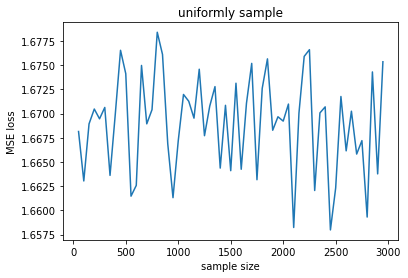

In [157]:
plt.plot(sample_size_range, np.mean(mean_loss,axis=0))
plt.title("uniformly sample")
plt.xlabel("sample size")
plt.ylabel("MSE loss")

### Baseline 2: best situation

In [151]:
hidden_dim = [128,128,128]
spectral_norms = [False]*len(hidden_dim)
best_nn = MLP(options["dim_x"], 1, hidden_dim, spectral_norms)
criterion = nn.MSELoss()
optimizer = optim.SGD(best_nn.parameters(), lr=0.001, momentum=0.9)

With known environment variables, largely select on the most related source tasks. Here, the most related tasks is the same environment with target task (same wind condition)

In [152]:
v = [0.9, 0.02, 0.02, 0.02, 0.02, 0.02]
sample_size_range = np.arange(50,3000,50)
best_mean_loss = []
for episode in range(10):
  best_nn,loss_lst = run(best_nn, optimizer, criterion, v, sample_size_range, 50)
  best_mean_loss.append(loss_lst)

Text(0, 0.5, 'MSE loss')

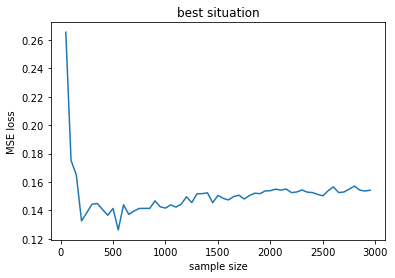

In [158]:
plt.plot(sample_size_range, np.mean(best_mean_loss,axis=0))
plt.title("best situation")
plt.xlabel("sample size")
plt.ylabel("MSE loss")

### Compare

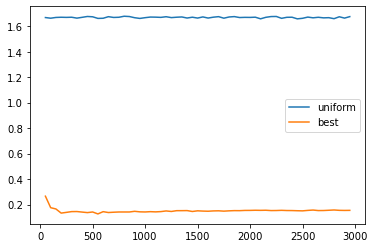

In [154]:
plt.plot(sample_size_range, np.mean(mean_loss,axis=0), label = "uniform")
plt.plot(sample_size_range, np.mean(best_mean_loss,axis=0), label = "best")
plt.legend()
plt.show()

In [ ]:
hidden_dim = [128,128,128]
spectral_norms = [False]*len(hidden_dim)
test_nn = MLP(options["dim_x"], 1, hidden_dim, spectral_norms)
criterion = nn.MSELoss()
optimizer = optim.SGD(test_nn.parameters(), lr=0.001, momentum=0.9)
v = np.array([1]*len(all_data.keys()))
v = v / (len(all_data.keys()))
sample_size_range = np.arange(500,10000,500)
test_mean_loss = []
for episode in range(10):
  test_nn,loss_lst = run(test_nn, optimizer, criterion, v, sample_size_range, 50)
  test_mean_loss.append(loss_lst)
plt.plot(sample_size_range, np.mean(test_mean_loss,axis=0))